In [1]:

import heat_exchanger
from constants import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# increase figure size
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

In [2]:

# read GA3_previous_desgins.csv

data = pd.read_csv('GA3_previous_designs.csv')

# remove weird group C designs
df = data[~(data["year"] == 2019)]
udf = data[data["year"] == 2019] # unseen designs

df = df[~((df["year"] == 2022) & (df["group"] == "Group-C"))] # remove group C 2022
df = df[~((df["year"] == 2023) & (df["group"] == "Group-C"))] # remove group C 2023
udf


,year,group,Tube Length,Tubes,Baffles,Pattern,Side,Rotameter in1,Rotameter out1,DP_meas1,...,DP_HX1,Qdot1,Flowrate2,DP_HX2,Qdot2,Qave,Effectiveness,Qcorr,Mass,Total Length
22,2019,Group-A,0.2217,"4,4,4,4","6,6",TRIANGLE,OPPOSITE,25,25,0.385,...,0.437,11.72,0.299,0.391,12.23,11.98,0.259,12.78,1.15,NaN
23,2019,Group-B,0.2260,"7,7","11,11",TRIANGLE,SAME,22,23,0.404,...,0.458,10.40,0.462,0.219,12.04,11.22,0.207,12.82,1.03,NaN
24,2019,Group-C,0.2220,"8,8",6,TRIANGLE,OPPOSITE,35,36,0.234,...,0.275,11.51,0.462,0.212,12.04,11.77,0.186,14.23,1.09,NaN
25,2019,Group-D,0.1930,"5,5,5,5","6,6",TRIANGLE,OPPOSITE,34,35,0.320,...,0.362,14.27,0.349,0.348,13.14,13.71,0.282,16.27,1.16,NaN
26,2019,Group-E,0.2120,"9,9",8,TRIANGLE,OPPOSITE,36,37,0.286,...,0.325,15.35,0.483,0.200,14.38,14.87,0.216,17.24,1.11,NaN
27,2019,Group-E,0.2120,"9,9",8,TRIANGLE,OPPOSITE,36,37,0.283,...,0.322,15.86,0.479,0.201,14.27,15.07,0.219,17.37,1.11,NaN
28,2019,Group-D,0.1930,"5,5,5,5","6,6",TRIANGLE,OPPOSITE,34,35,0.317,...,0.359,13.80,0.354,0.348,12.60,13.20,0.267,15.62,1.16,NaN
29,2019,Group-C,0.2220,"8,8",6,TRIANGLE,OPPOSITE,35,36,0.228,...,0.269,11.26,0.476,0.199,13.38,12.32,0.187,14.76,1.09,NaN
30,2019,Group-B,0.2260,"7,7","11,11",TRIANGLE,SAME,22,23,0.395,...,0.449,10.24,0.462,0.223,12.23,11.23,0.203,12.59,1.03,NaN
31,2019,Group-A,0.2217,"4,4,4,4","6,6",TRIANGLE,OPPOSITE,25,25,0.370,...,0.422,10.34,0.299,0.400,11.12,10.73,0.252,12.44,1.15,NaN


In [3]:

HX = heat_exchanger.build_heat_exchanger([2],[2], 0.31, Side.OPPOSITE, Pattern.SQUARE)
HX.set_conditions([20, 60])


In [4]:
def comptute_designs(df):
    mdot_colds = np.zeros(len(df))
    mdot_hots = np.zeros(len(df))
    Qdots = np.zeros(len(df))
    effs = np.zeros(len(df))

    hot_passes = np.zeros(len(df))
    cold_passes = np.zeros(len(df))

    for i, row in enumerate(df.iterrows()):
        
        tubes = str(row[1]["Tubes"]).split(",")
        tubes = [int(t) for t in tubes]
        baffles = str(row[1]["Baffles"]).split(",")
        baffles = [int(b) for b in baffles]
        length = float(row[1]["Tube Length"])

        hot_passes[i] = len(tubes)
        cold_passes[i] = len(baffles)

        pattern_str = row[1]["Pattern"]
        if pattern_str == "SQUARE":
            pattern = Pattern.SQUARE
        elif pattern_str == "TRIANGLE":
            pattern = Pattern.TRIANGLE
        
        HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
        HX.set_conditions([20, 60])
        HX.characteristic_year = row[1]["year"]

        result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

        if not result:
            continue

        Qdots[i] = HX.Qdot
        effs[i] = HX.effectiveness
        mdot_colds[i] = HX.mdot[0]
        mdot_hots[i] = HX.mdot[1]
    
    return Qdots, effs, mdot_colds, mdot_hots, hot_passes, cold_passes

Qdots, effs, mdot_colds, mdot_hots, hot_passes, cold_passes = comptute_designs(df)
uQdots, ueffs, umdot_colds, umdot_hots, u_hot_passes, u_cold_passes = comptute_designs(udf) # unseen designs

[0.99188804 0.10672778]
The correlation coefficient is:  0.9177171466551675


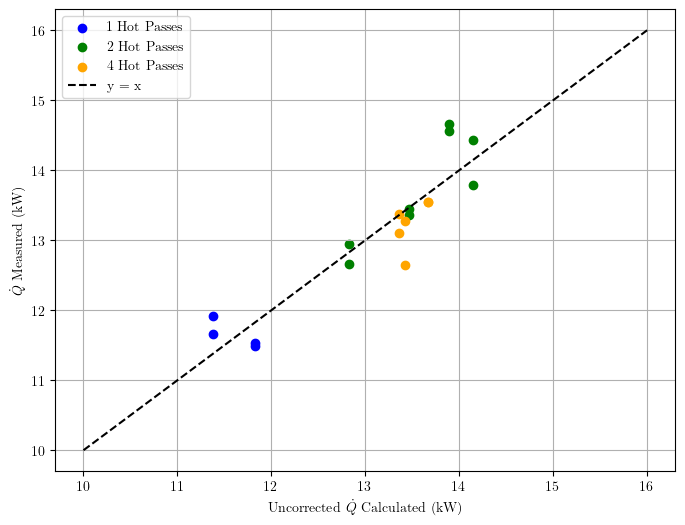

In [5]:
# plot Qdot calculated vs Qdot measured

lin = np.linspace(10, 16, 100)

Qdot_meas = df["Qcorr"]
uQdot_meas = udf["Qcorr"]

plt.figure()
cols = {1 : "blue", 2 : "green", 4 : "orange"}
marks = ["2022, 2023", "2019"]
for p in [1, 2, 4]:
    plt.scatter(Qdots[hot_passes == p] / 1e3, Qdot_meas[hot_passes == p], c = cols[p], label = f"{p} Hot Passes")
    #plt.scatter(uQdots[u_hot_passes == p] / 1e3, uQdot_meas[u_hot_passes == p], marker="^", c = cols[p])

plt.plot(lin, lin, linestyle="--", color="black", label = "y = x")
# colorbar

qdot_fit = np.polyfit(Qdots / 1e3, Qdot_meas, 1)
qdot_fit_fn = np.poly1d(qdot_fit)
print(qdot_fit)
print("The correlation coefficient is: ", np.corrcoef(Qdots / 1e3, Qdot_meas)[0, 1])
#plt.plot(lin, qdot_fit_fn(lin), "--", label=f"y = {qdot_fit[0]:.2f}x + {qdot_fit[1]:.2f}", color="red")

plt.xlabel("Uncorrected $\dot{Q}$ Calculated (kW)")
plt.ylabel("$\dot{Q}$ Measured (kW)")
#plt.title("$\dot{Q}$ calculated vs $\dot{Q}$ measured")
plt.legend()
plt.grid()

plt.savefig("Qdot_ucalc_vs_measured.png", dpi=300)

In [6]:
df2024 = pd.read_csv('2024designs.csv')

Qdots2024, effs2024, mdot_colds2024, mdot_hots2024, hot_passes2024, cold_passes2024 = comptute_designs(df2024)

In [18]:
from scipy import stats
def stat_fit(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    cfd_lvl = 0.5
    n = len(x)
    dof = n-2
    t = stats.t.ppf(1 - (1 - cfd_lvl) / 2, dof)
    xfit = np.linspace(np.min(x) - 2, np.max(x) + 2, 200)
    yfit = slope * xfit + intercept
    
    slope_ci = t * std_err
    intercept_ci = t * std_err * np.sqrt(1/n + np.mean(x)**2/np.sum((x-np.mean(x))**2))
    y_upper = (slope + slope_ci) * xfit + (intercept + intercept_ci)
    y_lower = (slope - slope_ci) * xfit + (intercept - intercept_ci)

    return xfit, yfit, y_upper, y_lower

[0.99188804 0.10672778]


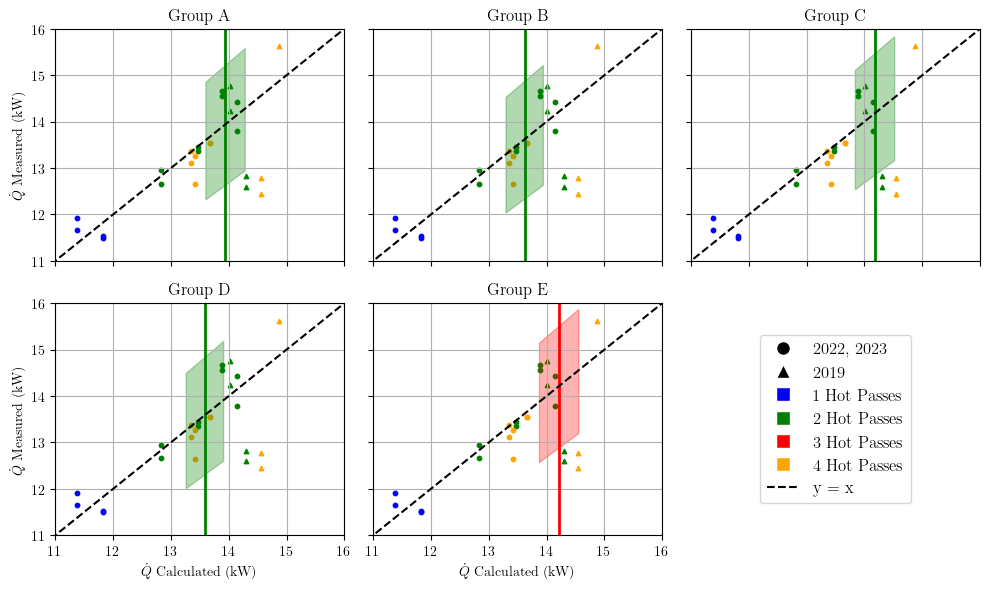

In [19]:
# plot Qdot calculated vs Qdot measured

zoomout = True

u_qdot_calc = 0.025
u_qdot_meas = 0.06

lin = np.linspace(10, 16, 100)

Qdot_meas = df["Qcorr"]
uQdot_meas = udf["Qcorr"]

fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

cols = {1 : "blue", 2 : "green", 3 : "red", 4 : "orange"}
marks = ["2022, 2023", "2019"]
groups = ["A", "B", "C", "D", "E"]

marker_labels = [plt.Line2D([0], [0], marker=marker, color='w', label=marks[i], 
                              markerfacecolor='k', markersize=10) for i, marker in enumerate(["o", "^"])]
shaded_area_label = plt.Line2D([0], [0], color='grey', label='2024 Bands', marker='s', markersize=10, alpha=0.8, linewidth = 0)
colour_labels = [plt.Line2D([0], [0], marker='s', color='w', label=f'{p} Hot Passes', 
                              markerfacecolor=cols[p], markersize=10) for p in [1, 2, 3, 4]]
xy_label = plt.Line2D([0], [0], linestyle="--", color='black', label='y = x')

legend_elements =  marker_labels + colour_labels + [xy_label]

qdot_fit = np.polyfit(Qdots / 1e3, Qdot_meas, 1)
qdot_fit_fn = np.poly1d(qdot_fit)
print(qdot_fit)
xfit, yfit, y_upper, y_lower = stat_fit(Qdots / 1e3, Qdot_meas)
#plt.plot(lin, qdot_fit_fn(lin), label=f"y = {qdot_fit[0]:.2f}x + {qdot_fit[1]:.2f}")

plot_index = 0
while plot_index < 5:
    ax = axes[plot_index // 3, plot_index % 3]

    for p in [1, 2, 3, 4]:
        ax.scatter(Qdots[hot_passes == p] / 1e3, Qdot_meas[hot_passes == p], c = cols[p], s = 10)
        ax.scatter(uQdots[u_hot_passes == p] / 1e3, uQdot_meas[u_hot_passes == p], marker="^", c = cols[p], s=10)

    qdoti = Qdots2024[plot_index] / 1e3
    ax.axvline(qdoti, color=cols[hot_passes2024[plot_index]], linewidth = 2)
    qdotis = xfit[(xfit >= qdoti * (1 - u_qdot_calc)) & (xfit <= qdoti * (1 + u_qdot_calc))]
    y_lowers = y_lower[(xfit >= qdoti * (1 - u_qdot_calc)) & (xfit <= qdoti * (1 + u_qdot_calc))]
    y_uppers = y_upper[(xfit >= qdoti * (1 - u_qdot_calc)) & (xfit <= qdoti * (1 + u_qdot_calc))]
    ax.fill_between(qdotis, y_lowers, y_uppers, color=cols[hot_passes2024[plot_index]], alpha=0.3)
    
    ax.plot(lin, lin, linestyle="--", color="black")

    ax.set_title(f"Group {groups[plot_index]}")
    if plot_index > 2:
        ax.set_xlabel("$\dot{Q}$ Calculated (kW)")
    if plot_index % 3 == 0:
        ax.set_ylabel("$\dot{Q}$ Measured (kW)")
    #plt.title("$\dot{Q}$ calculated vs $\dot{Q}$ measured")
    ax.set_ylim(11, 16)
    ax.set_xlim(11, 16)
    #ax.set_xlim(0, 30)
    #ax.set_ylim(0, 30)

    #ax.legend(handles=legend_elements)
    ax.grid()

    plot_index += 1

# make axes at 2,3 just a big legend
legend_axis = axes[1,2]
legend_axis.axis("off")
legend_axis.legend(handles=legend_elements, loc="center", ncol=1, fontsize=12)

plt.tight_layout()
plt.savefig("Qdot_uncertainty_bands.png", dpi=300)

# Doesnt look terrible

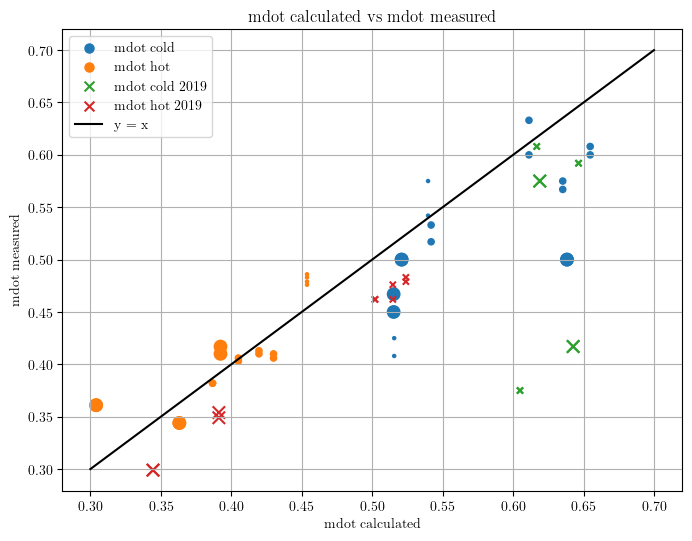

In [9]:
# plot mdot cold and mdot hot
lin = np.linspace(0.3, 0.7, 100)

plt.figure()
plt.scatter(mdot_colds, df["Flowrate1"], s=5 * hot_passes ** 2, label="mdot cold")
plt.scatter(mdot_hots, df["Flowrate2"],  s=5 * hot_passes ** 2, label="mdot hot")
plt.scatter(umdot_colds, udf["Flowrate1"], s=5 * u_hot_passes ** 2, label="mdot cold 2019", marker="x")
plt.scatter(umdot_hots, udf["Flowrate2"], s=5 * u_hot_passes ** 2, label="mdot hot 2019", marker="x")
plt.plot(lin, lin, color = "black", label="y = x")

plt.xlabel("mdot calculated")
plt.ylabel("mdot measured")
plt.title("mdot calculated vs mdot measured")
plt.grid()
plt.legend()

# looks terrible need to fix

[ 9.31806394e-01 -1.00644936e+03]


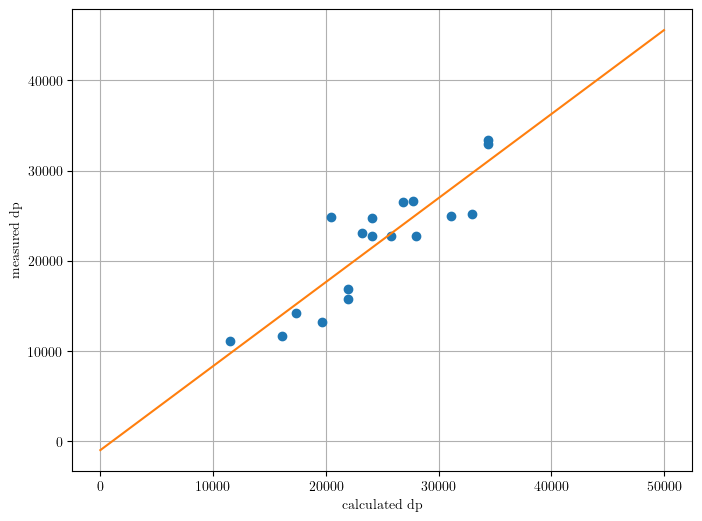

In [10]:
from heat_exchanger import dp_from_cold_mass_flow
# plot cold dp vs measured dp at measured mass flow

measured_cold_mdot = df["Flowrate1"]
measured_cold_dp = df[" DP_meas1"] * 1e5

calc_cold_dp = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    calc_cold_dp[i] = dp_from_cold_mass_flow(row[1]["Flowrate1"], row[1]["year"])

linearfit = np.polyfit(calc_cold_dp, measured_cold_dp, 1)
linearfit_fn = np.poly1d(linearfit)
print(linearfit)

x = np.linspace(0, 5e4, 100)

plt.figure()
plt.plot(calc_cold_dp, measured_cold_dp, 'o')
plt.plot(x, linearfit_fn(x))
plt.xlabel("calculated dp")
plt.ylabel("measured dp")

plt.grid()
plt.show()


# same thing for hot

from heat_exchanger import hot_mass_flow_from_dp



mdot_hot_calc = np.zeros(len(df))
for i,row in enumerate(df.iterrows()):
    mdot_hot_calc[i] = hot_mass_flow_from_dp( * 1e5, row[1]["year"])




[ 1.18073779e+00 -5.91294176e+03]


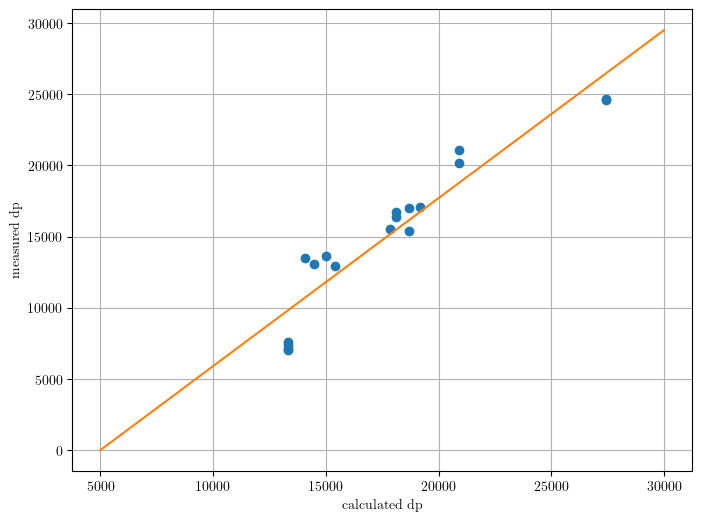

In [11]:
from heat_exchanger import dp_from_hot_mass_flow

measured_dp_hot = df["  DP_meas2"] * 1e5
calc_dp_hot = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    calc_dp_hot[i] = dp_from_hot_mass_flow(row[1]["Flowrate2"], row[1]["year"])

linearfit = np.polyfit(calc_dp_hot, measured_dp_hot, 1)
linearfit_fn = np.poly1d(linearfit)
print(linearfit)

x = np.linspace(5e3, 3e4, 100)

plt.figure()
plt.plot(calc_dp_hot, measured_dp_hot, 'o')
plt.plot(x, linearfit_fn(x))
plt.xlabel("calculated dp")
plt.ylabel("measured dp")

plt.grid()

In [12]:
dp_colds = np.zeros(len(df))
dp_hots = np.zeros(len(df))
Qdots = np.zeros(len(df))
effs = np.zeros(len(df))

hot_passes = np.zeros(len(df))
cold_passes = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    
    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]
    baffles = str(row[1]["Baffles"]).split(",")
    baffles = [int(b) for b in baffles]
    length = float(row[1]["Tube Length"])

    hot_passes[i] = len(tubes)
    cold_passes[i] = len(baffles)

    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE
    
    HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
    HX.set_conditions([20, 60])
    HX.characteristic_year = row[1]["year"]

    result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

    if not result:
        continue

    Qdots[i] = HX.Qdot
    effs[i] = HX.effectiveness
    dp_colds[i], dp_hots[i] = HX.calc_dp(HX.mdot)

udp_colds = np.zeros(len(udf))
udp_hots = np.zeros(len(udf))
uQdots = np.zeros(len(udf))
ueffs = np.zeros(len(udf))

uhot_passes = np.zeros(len(udf))
ucold_passes = np.zeros(len(udf))

for i, row in enumerate(udf.iterrows()):

    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]
    baffles = str(row[1]["Baffles"]).split(",")
    baffles = [int(b) for b in baffles]
    length = float(row[1]["Tube Length"])

    uhot_passes[i] = len(tubes)
    ucold_passes[i] = len(baffles)
    
    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE

    HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
    HX.set_conditions([20, 60])
    HX.characteristic_year = row[1]["year"]

    result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

    if not result:
        continue

    uQdots[i] = HX.Qdot
    ueffs[i] = HX.effectiveness
    udp_colds[i], udp_hots[i] = HX.calc_dp(HX.mdot)
    

[7.50866740e-01 2.51828179e+03]
[ 2.33387913e+00 -2.28484123e+04]
The correlation coefficient for hot fit is:  0.9307368241721075
The correlation coefficient for cold fit is:  0.6944847104599939


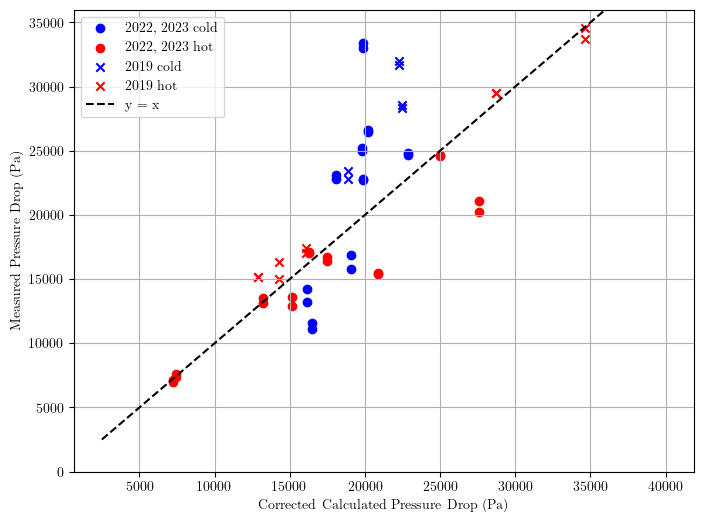

In [13]:

# plot

plt.figure()
plt.scatter(dp_colds, measured_cold_dp, c='blue', marker = 'o', label = "2022, 2023 cold")
plt.scatter(dp_hots, measured_dp_hot, c='red', marker = 'o',  label = "2022, 2023 hot")

plt.scatter(udp_colds, udf[" DP_meas1"] * 1e5, c='blue', marker = 'x', label = "2019 cold")
plt.scatter(udp_hots, udf["  DP_meas2"] * 1e5, c='red', marker = 'x', label = "2019 hot")

hot_lin_fit = np.polyfit(dp_hots, measured_dp_hot, 1)
hot_lin_fit_f  = np.poly1d(hot_lin_fit)
cold_lin_fit = np.polyfit(dp_colds, measured_cold_dp, 1)
cold_lin_fit_f = np.poly1d(cold_lin_fit)

print(hot_lin_fit)
print(cold_lin_fit)

x = np.linspace(2.5e3, 4e4, 100)

plt.plot(x, x, 'k--', label = "y = x")
#plt.plot(x, hot_lin_fit_f(x), 'r--', label = f"y = {hot_lin_fit[0]:.2f}x + {hot_lin_fit[1]:.2f}")
print("The correlation coefficient for hot fit is: ", np.corrcoef(dp_hots, measured_dp_hot)[0,1])
#plt.plot(x, cold_lin_fit_f(x), 'b--', label = f"y = {cold_lin_fit[0]:.2f}x + {cold_lin_fit[1]:.2f}")
print("The correlation coefficient for cold fit is: ", np.corrcoef(dp_colds, measured_cold_dp)[0,1])
plt.xlabel("Corrected Calculated Pressure Drop (Pa)")
plt.ylabel("Measured Pressure Drop (Pa)")

plt.ylim(0, 3.6e4)
plt.grid()
plt.legend()
plt.savefig("dp_calc_vs_meas.png", dpi = 300)

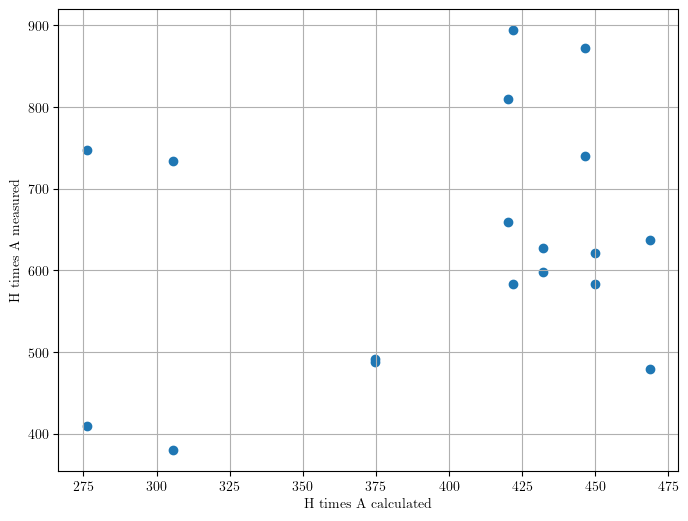

In [14]:
from heat_exchanger import logmeanT

dhas = np.zeros(len(df))

Qdots = np.zeros(len(df))
effs = np.zeros(len(df))

hot_passes = np.zeros(len(df))
cold_passes = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    
    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]
    baffles = str(row[1]["Baffles"]).split(",")
    baffles = [int(b) for b in baffles]
    length = float(row[1]["Tube Length"])

    hot_passes[i] = len(tubes)
    cold_passes[i] = len(baffles)

    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE
    
    HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
    HX.set_conditions([20, 60])
    HX.characteristic_year = row[1]["year"]

    result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

    if not result:
        continue

    Qdots[i] = HX.Qdot
    effs[i] = HX.effectiveness
    dhas[i] = HX.calc_area_times_H(HX.mdot)


plt.figure()

lgmt = logmeanT(df[" Tcold_in"], df[" Tcold_out"], df[" Thot_in"], df[" Thot_out"])
dhs_exp = 1e3 * df["Qcorr"] / lgmt

plt.scatter(dhas, dhs_exp)
plt.xlabel("H times A calculated")
plt.ylabel("H times A measured")

plt.grid()
plt.show()

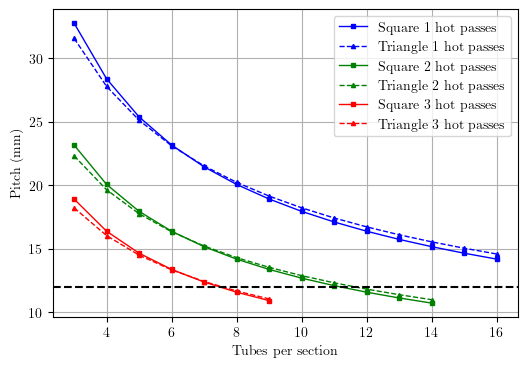

In [15]:
from heat_exchanger import pitch_from_tubes

plt.rcParams["figure.figsize"] = (6, 4)

hot_sects = [1,2,3]
max_tubes = [16,14,9]
colours = ["blue", "green", "red"]

plt.figure()

for i in range(3):

    tubes = np.arange(3, max_tubes[i] + 1)
    sq_pitches = np.zeros(tubes.size)
    tr_pitches = np.zeros(tubes.size)

    for j,n in enumerate(tubes):
        sq_pitches[j] = 1e3 * pitch_from_tubes(n, i+1, Pattern.SQUARE)
        tr_pitches[j] = 1e3 * pitch_from_tubes(n, i+1, Pattern.TRIANGLE)

    #plt.scatter(tubes, sq_pitches, label="Square", marker = "s", s=20, c=colours[i], alpha=0.5)
    #plt.scatter(tubes, tr_pitches, label="Triangle", marker = "^", s=20, c=colours[i], alpha=0.5)
    plt.plot(tubes, sq_pitches, label=f"Square {hot_sects[i]} hot passes", marker = "s", c=colours[i], markersize=3, linewidth=1)
    plt.plot(tubes, tr_pitches, label=f"Triangle {hot_sects[i]} hot passes", marker = "^", c=colours[i], linestyle="--", markersize=3, linewidth=1)


plt.axhline(12, color="black", linestyle="--")
plt.grid()
plt.xlabel("Tubes per section")
plt.ylabel("Pitch (mm)")
plt.legend()

plt.savefig("pitch_vs_tubes.png", dpi=300)


In [16]:
from heat_exchanger_perturbed import Heat_Exchanger_Perturbed

def dQdot_dpitch(HX, dpitch):
    hxa = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxb = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxc = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxa.set_conditions(HX.Tin)
    hxb.set_conditions(HX.Tin)
    hxc.set_conditions(HX.Tin)
    hxa.L_hot_tube = HX.L_hot_tube
    hxb.L_hot_tube = HX.L_hot_tube
    hxc.L_hot_tube = HX.L_hot_tube
    mean_pitch = np.mean(HX.get_pitch())
    mean_baffle_spacing = HX.L_hot_tube / (HX.total_baffles / HX.cold_flow_sections - 1)

    resa = hxa.compute_effectiveness(mean_pitch - dpitch, mean_baffle_spacing)
    resb = hxb.compute_effectiveness(mean_pitch, mean_baffle_spacing)
    resc = hxc.compute_effectiveness(mean_pitch + dpitch, mean_baffle_spacing)

    if not resa or not resb or not resc:
        return None

    return np.abs(hxc.Qdot - hxa.Qdot) / (2 * hxb.Qdot)

def dQdot_dbaffle_spacing(HX, dbaffle_spacing):
    hxa = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxb = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxc = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxa.set_conditions(HX.Tin)
    hxb.set_conditions(HX.Tin)
    hxc.set_conditions(HX.Tin)
    hxa.L_hot_tube = HX.L_hot_tube
    hxb.L_hot_tube = HX.L_hot_tube
    hxc.L_hot_tube = HX.L_hot_tube
    mean_pitch = np.mean(HX.get_pitch())
    mean_baffle_spacing = HX.L_hot_tube / (HX.total_baffles / HX.cold_flow_sections - 1)

    resa = hxa.compute_effectiveness(mean_pitch, mean_baffle_spacing - dbaffle_spacing)
    resb = hxb.compute_effectiveness(mean_pitch, mean_baffle_spacing)
    resc = hxc.compute_effectiveness(mean_pitch, mean_baffle_spacing + dbaffle_spacing)

    if not resa or not resb or not resc:
        return None

    return np.abs(hxc.Qdot - hxa.Qdot) / (2 * hxb.Qdot)

def dQdot_dlength(HX, dlength):
    hxa = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxb = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxc = Heat_Exchanger_Perturbed(HX.cold_path, HX.hot_path, HX.flow_path_entries_side)
    hxa.set_conditions(HX.Tin)
    hxb.set_conditions(HX.Tin)
    hxc.set_conditions(HX.Tin)
    hxa.L_hot_tube = HX.L_hot_tube - dlength
    hxb.L_hot_tube = HX.L_hot_tube
    hxc.L_hot_tube = HX.L_hot_tube + dlength
    mean_pitch = np.mean(HX.get_pitch())
    mean_baffle_spacing = HX.L_hot_tube / (HX.total_baffles / HX.cold_flow_sections - 1)

    resa = hxa.compute_effectiveness(mean_pitch, mean_baffle_spacing)
    resb = hxb.compute_effectiveness(mean_pitch, mean_baffle_spacing)
    resc = hxc.compute_effectiveness(mean_pitch, mean_baffle_spacing)

    if not resa or not resb or not resc:
        return None

    return np.abs(hxc.Qdot - hxa.Qdot) / (2 * hxb.Qdot)



In [17]:
L = 0.29
HX = heat_exchanger.build_heat_exchanger([6,6],[8], L, Side.OPPOSITE, Pattern.SQUARE)
HX.set_conditions([20, 60])
baffle_spacing = L / (HX.total_baffles / HX.cold_flow_sections - 1)

one_percent = 1e-2

print("Baffle Spacing", 100 * dQdot_dbaffle_spacing(HX, -1e-3), "%")
print("Pitch", 100 * dQdot_dpitch(HX, 4e-3), "%")
print("Length", 100 * dQdot_dlength(HX, 1e-3), "%")

print("=====================================")

for i,row in enumerate(df2024.iterrows()):
    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]

    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE

    group = row[1]["group"]
    
    hot_stages = len(tubes)
    pitch = pitch_from_tubes(tubes[0], hot_stages, pattern)
    print(f"Design {i} by {group} has a calculated pitch of {pitch * 1e3:.2f} mm")

Baffle Spacing 0.005282047627317991 %
Pitch 2.4122540859430477 %
Length 0.11443475608675288 %
Design 0 by Group-A has a calculated pitch of 16.33 mm
Design 1 by Group-B has a calculated pitch of 16.33 mm
Design 2 by Group-C has a calculated pitch of 16.33 mm
Design 3 by Group-D has a calculated pitch of 15.21 mm
Design 4 by Group-E has a calculated pitch of 14.49 mm
